#Pretraining on Unlabeled Data

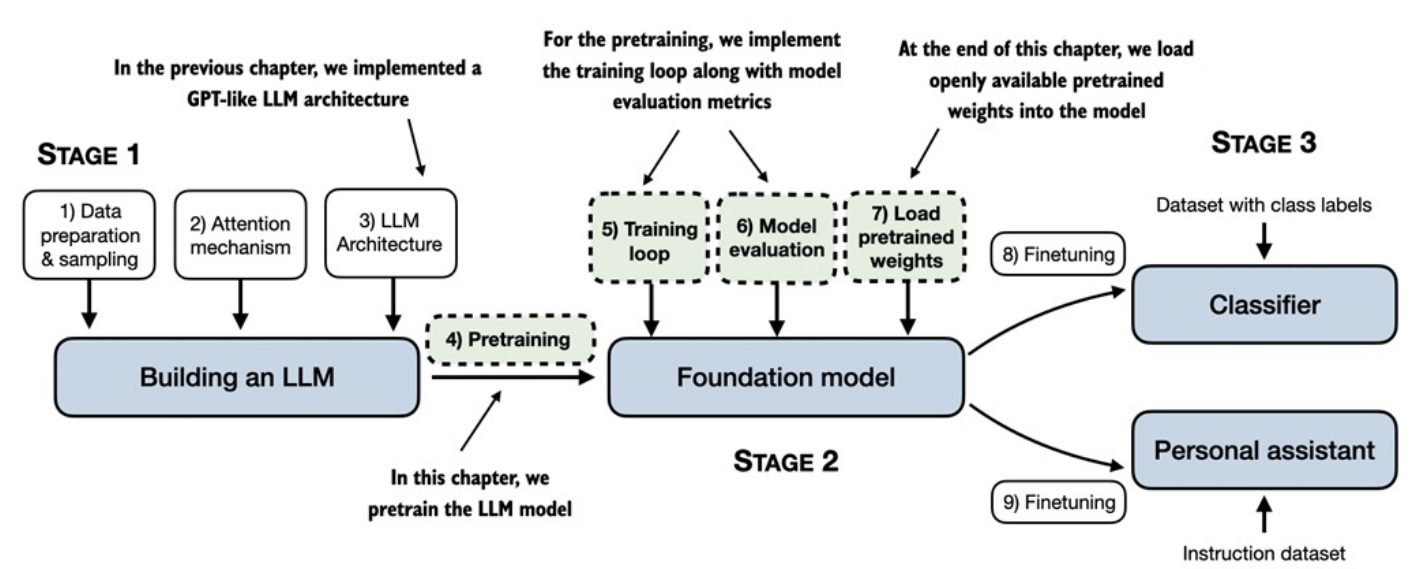

**A mental model of the three main stages of coding an LLM, pretraining the LLM on a
general text dataset and finetuning it on a labeled dataset. This chapter focuses on pretraining the
LLM, which includes implementing the training code, evaluating the performance, and saving
and loading model weights**

------------------------------------------------------------------------------------------
In the context of LLMs and other deep learning models, weights refer to the
trainable parameters that the learning process adjusts. These weights are also
known as weight parameters or simply parameters. In frameworks like
PyTorch, these weights are stored in linear layers, for example, which we
used to implement the multi-head attention module and GPTModel in previous chapters. After initializing a layer `(new_layer =
torch.nn.Linear(...))`, we can access its weights through the .weight
attribute, `new_layer.weight`. Additionally, for convenience, PyTorch allows
direct access to all a model's trainable parameters, including weights and
biases, through the method `model.parameters()`, which we will use later
when implementing the model training.

#5.1 Evaluating generative text models

In [ ]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

SyntaxError: invalid syntax (<ipython-input-45-c89c65ab24f6>, line 1)

*  We start this section with a brief recap of initializing a GPT model using the code from the previous chapter
*  Then, we discuss basic evaluation metrics for LLMs
*  Lastly, in this section, we apply these evaluation metrics to a training and validation dataset

###5.1.1 Using GPT to generate text

*  We initialize a GPT model using the code from the previous chapter

In [ ]:
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#####################################
# Chapter 2
#####################################


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


#####################################
# Chapter 3
#####################################
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


#####################################
# Chapter 4
#####################################
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


if __name__ == "__main__":

    GPT_CONFIG_124M = {
        "vocab_size": 50257,     # Vocabulary size
        "context_length": 1024,  # Context length
        "emb_dim": 768,          # Embedding dimension
        "n_heads": 12,           # Number of attention heads
        "n_layers": 12,          # Number of layers
        "drop_rate": 0.1,        # Dropout rate
        "qkv_bias": False        # Query-Key-Value bias
    }

    torch.manual_seed(123)
    model = GPTModel(GPT_CONFIG_124M)
    model.eval()  # disable dropout

    start_context = "Hello, I am"

    tokenizer = tiktoken.get_encoding("gpt2")
    encoded = tokenizer.encode(start_context)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    print(f"\n{50*'='}\n{22*' '}IN\n{50*'='}")
    print("\nInput text:", start_context)
    print("Encoded input text:", encoded)
    print("encoded_tensor.shape:", encoded_tensor.shape)

    out = generate_text_simple(
        model=model,
        idx=encoded_tensor,
        max_new_tokens=10,
        context_size=GPT_CONFIG_124M["context_length"]
    )
    decoded_text = tokenizer.decode(out.squeeze(0).tolist())

    print(f"\n\n{50*'='}\n{22*' '}OUT\n{50*'='}")
    print("\nOutput:", out)
    print("Output length:", len(out[0]))
    print("Output text:", decoded_text)


                      IN

Input text: Hello, I am
Encoded input text: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


                      OUT

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657]])
Output length: 14
Output text: Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous


In [ ]:
import torch


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

*  We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays
*  Modern LLMs also don't use bias vectors in the nn.Linear layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting `"qkv_bias": False`
*  We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

  *  This is so that more readers will be able to follow and execute the code examples on their laptop computer
  *  However, please feel free to increase the context_length to 1024 tokens (this would not require any code changes)
  *  We will also load a model with a 1024 context_length later from pretrained weights

*  Next, we use the `generate_text_simple` function from the previous chapter to generate text

*  In addition, we define two convenience functions, `text_to_token_ids` and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

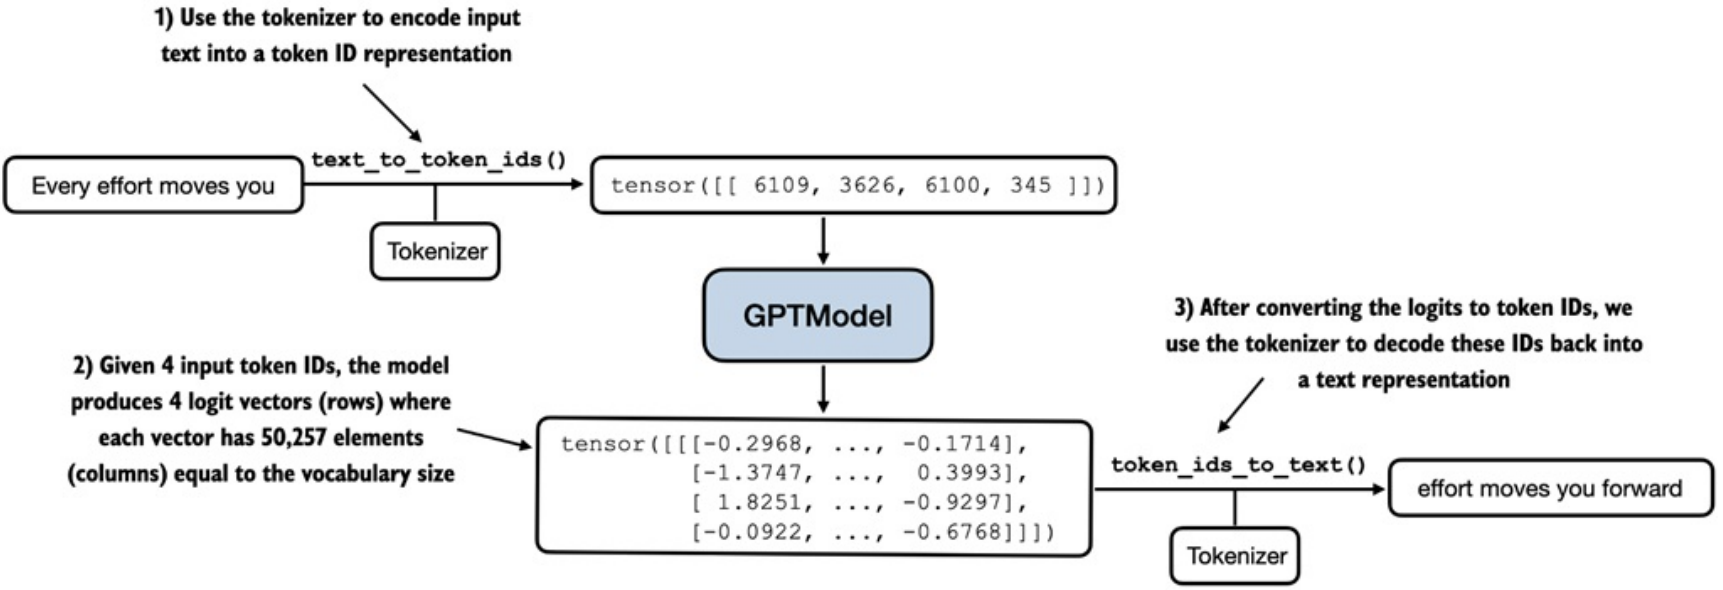

**Generating text involves encoding text into token IDs that the LLM processes into logit
vectors. The logit vectors are then converted back into token IDs, detokenized into a text
representation.**

**Listing 5.1 Utility functions for text to token ID conversion**

In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


*  As we can see above, the model does not produce good text because it has not been trained yet
*  How do we measure or capture what "good text" is, in a numeric form, to track it during training?
*  The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress
*  The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

--------------------------------------------------------------------------------------------
The following section introduces how we calculate a loss metric for the
generated outputs. This loss serves as a progress and success indicator of the
training progress. Furthermore, in subsequent chapters on finetuning LLMs,
we will review additional methodologies for assessing model quality.

##5.1.2 Calculating the text generation loss: cross-entropy and perplexity

*  Suppose we have an `inputs` tensor containing the token IDs for 2 training examples (rows)
*  Corresponding to the `inputs`, the `targets` contain the desired token IDs that we want the model to generate
*  Notice that the `targets` are the `inputs` shifted by 1 position, as explained in chapter 2 when we implemented the data loader

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

*  Feeding the `inputs` to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each
*  Each of the tokens is a `50,257-dimensional` vector corresponding to the size of the vocabulary
*  Applying the `softmax function`, we can turn the logits tensor into a tensor of the same dimension containing probability scores

In [ ]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


*  The figure below, using a very small vocabulary for illustration purposes, outlines how we convert the probability scores back into text, which we discussed at the end of the previous chapter

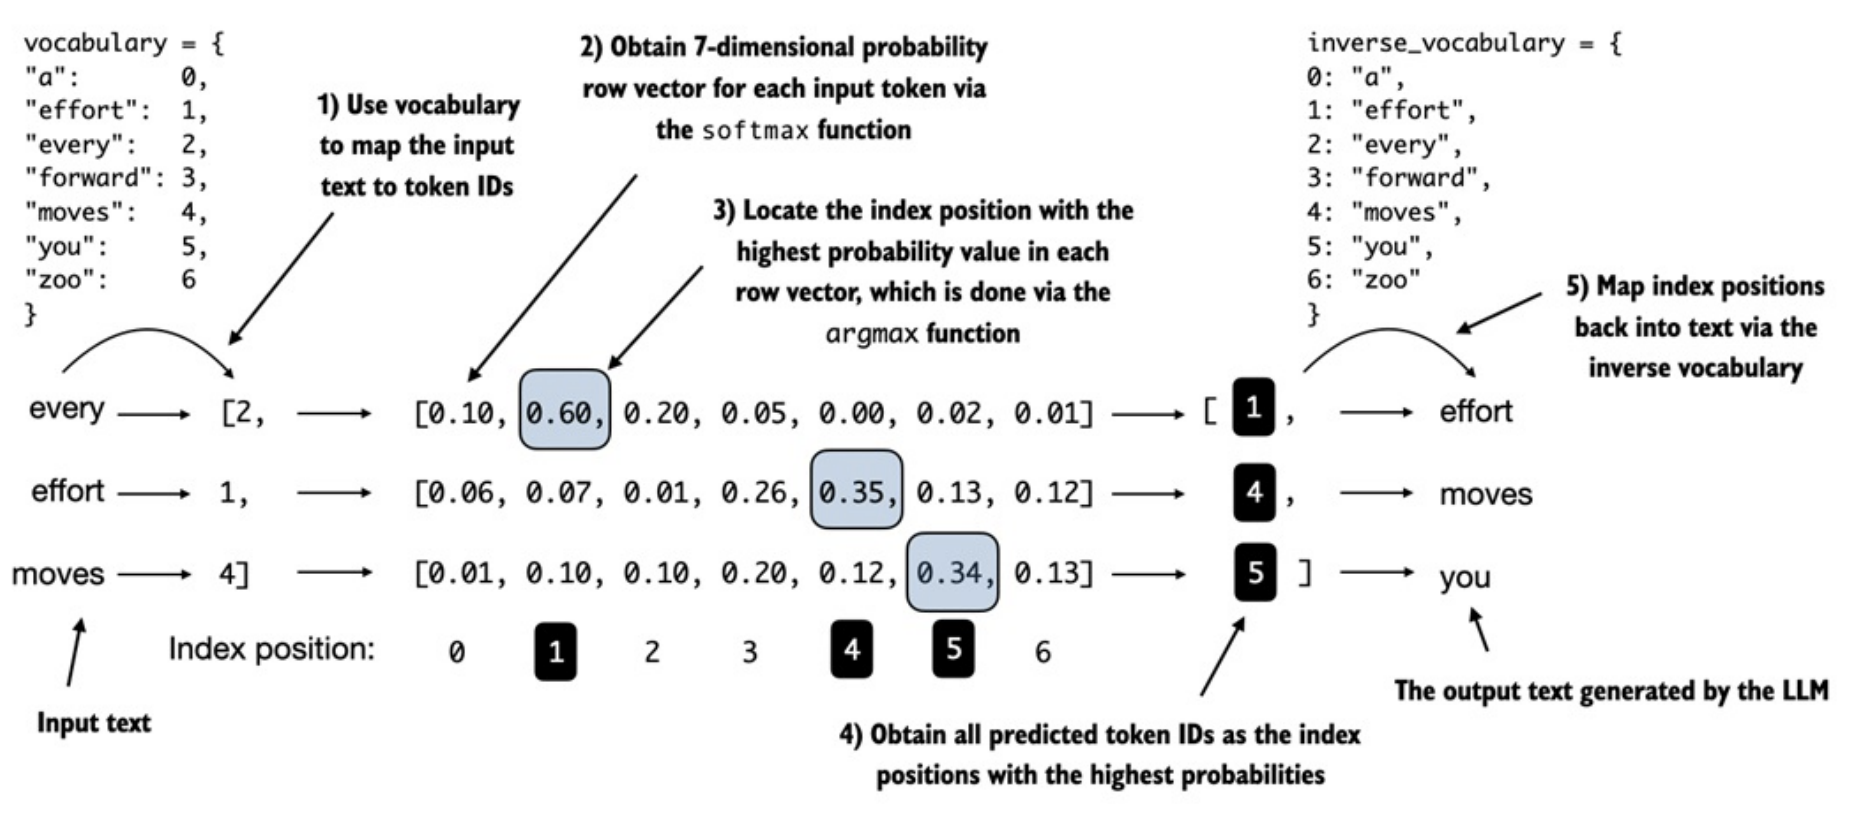

**For each of the 3 input tokens, shown on the left, we compute a vector containing
probability scores corresponding to each token in the vocabulary. The index position of the
highest probability score in each vector represents the most likely next token ID. These token IDs
associated with the highest probability scores are selected and mapped back into a text that
represents the text generated by the model.**

*  As discussed in the previous chapter, we can apply the argmax function to convert the probability scores into predicted token IDs
*  The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token

* Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:

In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


*  If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens:

In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


*  That's because the model wasn't trained yet
*  To train the model, we need to know how far it is away from the correct predictions (targets)

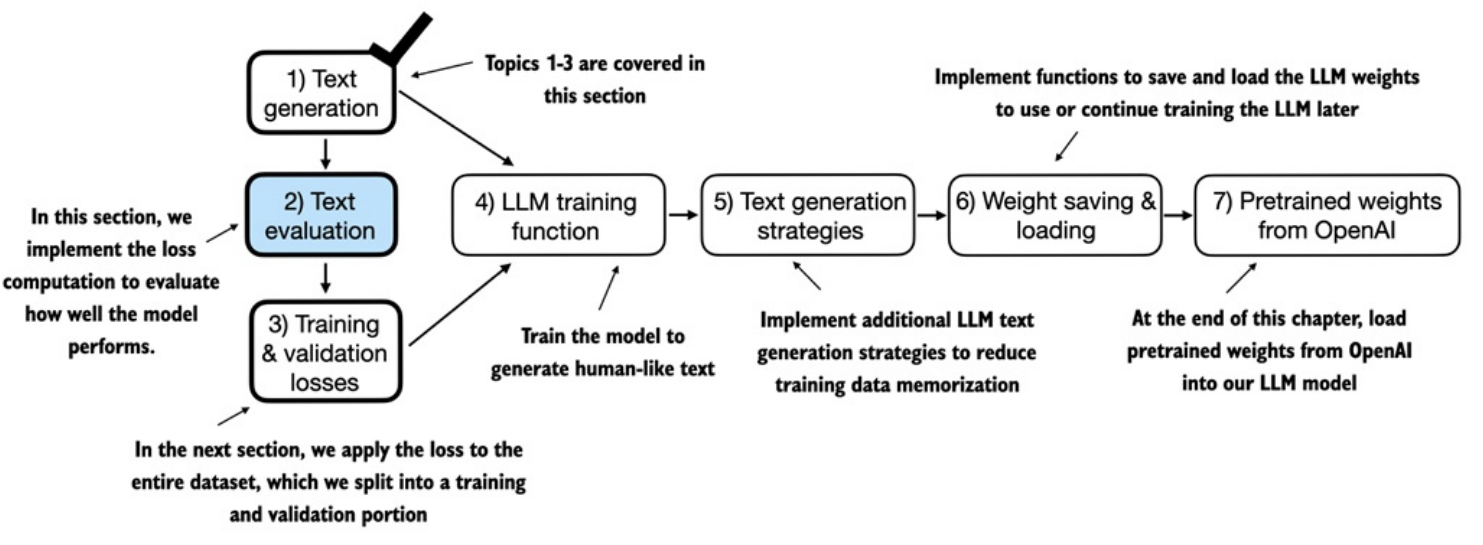

**We now implement the text evaluation function in the remainder of this section. In the
next section, we apply this evaluation function to the entire dataset we use for model training.**

The model training aims to increase the softmax probability in the index
positions corresponding to the correct target token IDs, as illustrated in
Figure below. This softmax probability is also used in the evaluation metric we
are implementing in the remainder of this section to numerically assess the
model's generated outputs: the higher the probability in the correct positions, the better.

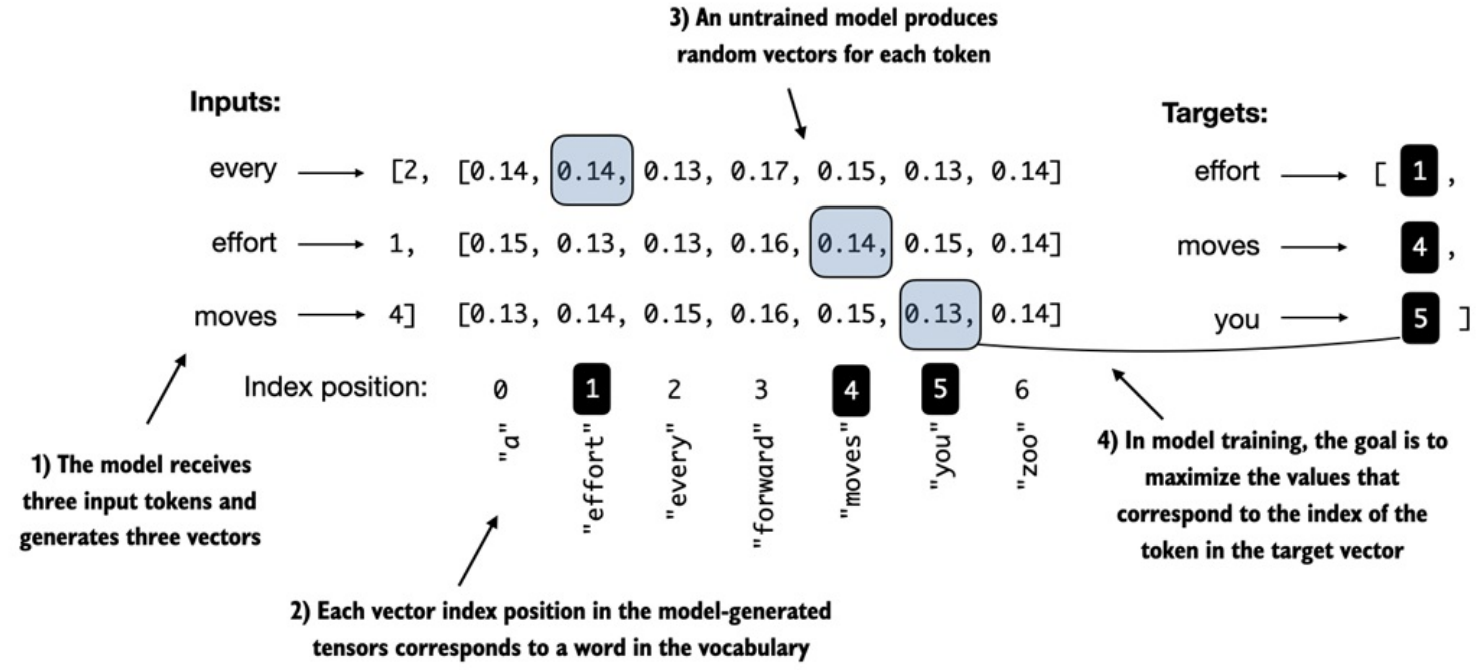

**Before training, the model produces random next-token probability vectors. The goal
of model training is to ensure that the probability values corresponding to the highlighted target
token IDs are maximized.**

The above figure displays the softmax probabilities for a compact 7-token vocabulary to fit everything into a single figure. This implies that the satrting random values will hover around 1/7, which equals approximately 0.14.

However, the vocabulary we are using for our GPT-2 model has 50,257 tokens, so most of the initial probabilities will over around 0.00002 via 1/50,257.


*For each of the two input texts, we can print the initial softmax probability scores corresponding to the target tokens*

In [ ]:
probas.shape

torch.Size([2, 3, 50257])

In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


*The goal of training an LLM is to maximize these values, aiming to get them as close to a probability to 1. This way, we ensure the LLM consistently picks the target token-especially the next word in the sentence-as the next token it generates.*

### Backpropogation

*  We want to maximize all these values, bringing them close to a probability of 1

*  In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself

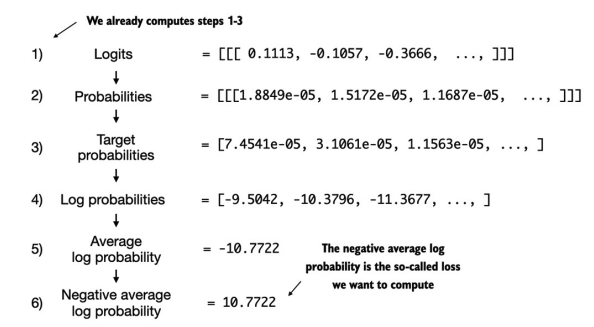

**Calculating the loss involves several steps. Steps 1 to 3 calculate the token probabilities
corresponding to the target tensors. These probabilities are then transformed via a logarithm and
averaged in steps 4-6**

----------------------------------------------------------------------------------------
Since we already applied steps 1-3 listed in the above figure to obtain `target_probas_1` and `target_probas_2`, we will proceed with step 4, now applying the `logarithm` to the probability scores

In [ ]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


*  Next we compute the average log probabilities:

In [ ]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


*  The goal is to make this average log probability as large as possible by optimizing the model weights
*  Due to the log, the largest possible value is 0, and we are currently far away from 0

---------------------------------------------------------------------------------------
* In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.7722 so that it approaches 0, in deep learning, we would minimize 10.7722 so that it approaches 0
* The value negative of -10.7722, i.e., 10.7722, is also called cross-entropy loss in deep learning

In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


* The term for this negative value, -10.7722 turning into 10.7722, is known as
the `cross entropy loss` in deep learning.

* PyTorch comes in handy here, as it already has a built-in cross_entropy
function that takes care of all these 6 steps in Figure above for us.

At its core, the cross entropy loss is a popular measure in machine learning
and deep learning that measures the difference between two probability
distributions--typically, the true distribution of labels (here, tokens in a
dataset) and the predicted distribution from a model (for instance, the token
probabilities generated by an LLM).

* Before we apply the cross entropy funtion, let's briefly recall the shape of the logits and target tensors:

In [ ]:
print("Logits shape:", logits.shape)
print("Targets shape", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape torch.Size([2, 3])


As we can see, the logits has three dimensions: batch size, number of tokens, and vocabulary size. The target tensor has two dimensions: batch size and number of tokens.

* For the `cross_entropy_loss` funtion in PyTorch, we want to flatten these tensors by combining them over the batch dimension

In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


* Remember that the targets are the token IDs we want the LLM to generate,
and the logits contain the unscaled model outputs before they enter the
softmax function to obtain the probability scores.

* Previously, we applied the softmax function, selected the probability scores
corresponding to the target IDs, and computed the negative average log
probabilities. PyTorch's cross_entropy function will take care of all these
steps for us:

In [ ]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


Perplexity measures how well the probability distribution predicted by the
model matches the actual distribution of the words in the dataset. Similar to
the loss, a lower perplexity indicates that the model predictions are closer to
the actual distribution.

* A concept related to the cross-entropy loss is the perplexity of an LLM
* The perplexity is simply the exponential of the cross-entropy loss

In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


* The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens)
* In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset
* Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution

## 5.1.3 Calculating the training and validation set losses

* We use a relatively small dataset for training the LLM (in fact, only one short story)

* The reasons are:

  * You can run the code examples in a few minutes on a laptop computer without a suitable GPU
  * The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes
  * We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights or bloating the repository size
* For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens

  * At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately $30
  * So, via an off the envelope calculation, training this LLM would cost 184,320 / 8 X 30 = 690,000 (dollars)
Below, we use the same dataset we used in previous chapters

In [ ]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

* A quick check that the text loaded ok by printing the first and last 100 words

In [ ]:
#First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [ ]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 20479
Total tokens: 5145


* With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later)
* Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
* For visualization purposes, the figure below assumes a max_length=6, but for the training loader, we set the max_length equal to the context length that the LLM supports
* The figure below only shows the input tokens for simplicity
  * Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

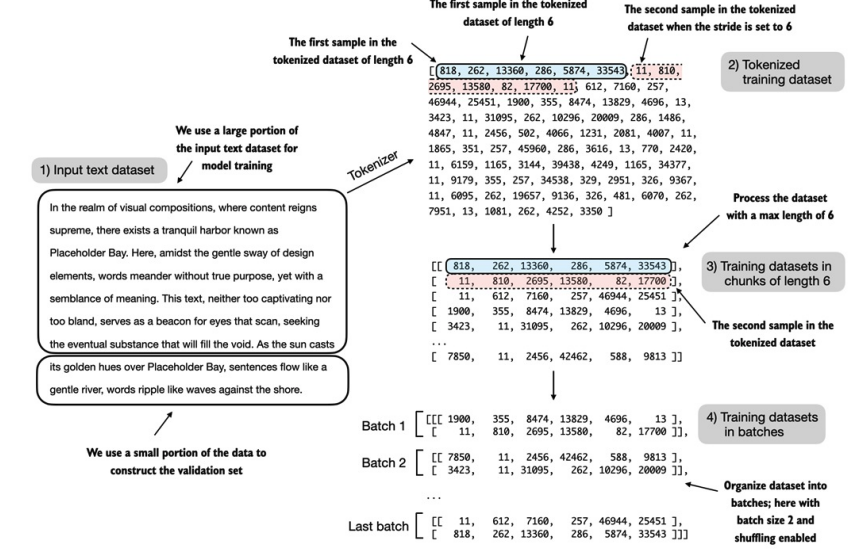

**When preparing the data loaders, we split the input text into training and validation
set portions. Then, we tokenize the text (only shown for the training set portion for simplicity)
and divide the tokenized text into chunks of a user-specified length (here 6). Finally, we shuffle
the rows and organize the chunked text into batches (here, batch size 2), which we can use for
model training.**

*For visualization purposes, Figure 5.9 uses a max_length=6 due to spatial
constraints. However, for the actual data loaders we are implementing, we set
the max_length equal to the 256-token context length that the LLM supports
so that the LLM sees longer texts during training.*

**Training with variable lengths**

* We are training the model with training data presented in similarly-sized
chunks for simplicity and efficiency. However, in practice, it can also be
beneficial to train an LLM with variable-length inputs to help the LLM to
better generalize across different types of inputs when it is being used.

* To implement the data splitting and loading visualized in Figure above, we first
define a train_ratio to use 90% of the data for training and the remaining
10% as validation data for model evaluation during training:

In [ ]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Using the train_data and val_data subsets, we can now create the
respective data loader reusing the create_dataloader_v1 code from previous chapter:

In [ ]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
train_data,
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=True,
shuffle=True
)
val_loader = create_dataloader_v1(
val_data,
batch_size=2,
max_length=GPT_CONFIG_124M["context_length"],
stride=GPT_CONFIG_124M["context_length"],
drop_last=False,
shuffle=False
)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

* We used a relatively small batch size in the preceding code to reduce the computiational resource demand because we were working with a very small dataset. In practise, training LLMs with the batch sizes of 1024 or larger is not uncommon.

* As an optional check, we can iterate throguh the data loaders to ensure that they were created correctly:

In [ ]:
print("Train loader:")
for x, y in train_loader:
  print(x.shape, y.shape)

print("\nValidation loader:")

for x, y in val_loader:
  print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


*Based on the preceding code output, we have 9 training set batches with 2
samples and 256 tokens each. Since we allocated only 10% of the data for
validation, there is only one validation batch consisting of 2 input examples.*

* Another optional check that the token sizes are in the expected ballpark:

In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


* Next, we implement a utility function to calculate the cross-entropy loss of a given batch
* In addition, we implement a second utility function to compute the loss for a user-specified number of batches in a data loader

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# Funtion to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

* If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
* Via the device setting, we ensure that the data is loaded onto the same device as the LLM model


----------------------------------------------------------------------------------------
By default, the calc_loss_batch function iterates over all batches in a given
data loader, accumulates the loss in the total_loss variable, and then
computes and averages the loss over the total number of batches.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


*The loss values are relatively high because the model has not yet been
trained. For comparison, the loss approaches 0 if the model learns to generate
the next tokens as they appear in the training and validation sets.*

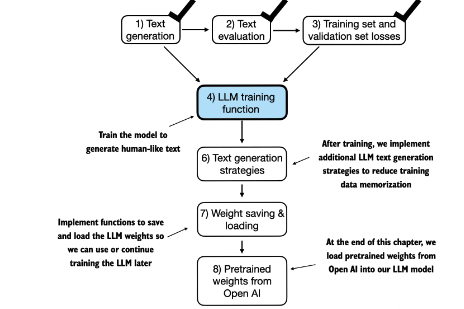

## 5.2 Training an LLM

* In this section, we finally implement the code for training the LLM
* We focus on a simple training function (we can also augment this training function with more advanced techniques, such as learning rate warmup, cosine annealing, and gradient clipping)

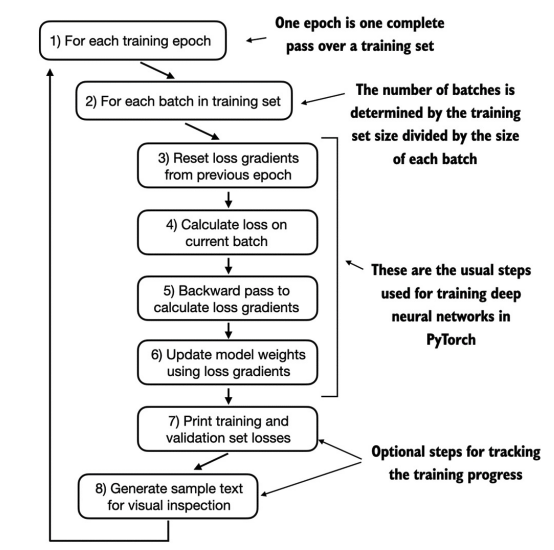

**A typical training loop for training deep neural networks in PyTorch consists of
several steps, iterating over the batches in the training set for several epochs. In each loop, we
calculate the loss for each training set batch to determine loss gradients, which we use to update
the model weights so that the training set loss is minimized.**

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

* Now, let's train the LLM using the training function defined above:

In [ ]:
# Note:
# Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.783, Val loss 9.927
Ep 1 (Step 000005): Train loss 7.985, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.753, Val loss 7.048
Ep 2 (Step 000015): Train loss 6.114, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.525, Val loss 6.490
Ep 3 (Step 000025): Train loss 5.324, Val loss 6.387
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 4.761, Val loss 6.360
Ep 4 (Step 000035): Train loss 4.461, Val loss 6.258
Every effort moves you of the to the picture--as of the picture--as I had been " it was his " I was the     "I was his I had been the his pictures--and it the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 3.833, Val loss 6.196
Every effort moves yo

*As we can see, based on the results printed during the training, the training
loss improves drastically, starting with a value of 9.558 and converging to
0.762. The language skills of the model have improved quite a lot. In the
beginning, the model is only able to append commas to the start context
("Every effort moves you,,,,,,,,,,,,") or repeat the word "and". At the
end of the training, it can generate grammatically correct text.*

-----------------------------------------------------------------------------------------
Before discussing the validation loss in more detail, let's create a simple plot
that shows the training and validation set losses side by side:

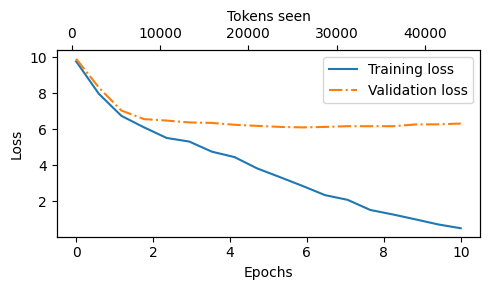

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

* Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
* However, based on the training and validation set losses, we can see that the model starts overfitting
* If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data
* Later, we will cover decoding strategies that can mitigate this memorization by a certain degree
* Note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times
  * The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  * Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later

## 5.3 Decoding strategies to control randomness

* Inference is relatively cheap with a relatively small LLM as the GPT model we trained above, so there's no need to use a GPU for it in case you used a GPU for training it above
* Using the generate_text_simple function (from the previous chapter) that we used earlier inside the simple training function, we can generate new text one word (or token) at a time
* As explained in section 5.1.2, the next generated token is the token corresponding to the largest probability score among all tokens in the vocabulary

In [ ]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




* Even if we execute the generate_text_simple function above multiple times, the LLM will always generate the same outputs
* We now introduce two concepts, so-called decoding strategies, to modify the generate_text_simple: temperature scaling and top-k sampling
* These will allow the model to control the randomness and diversity of the generated text

## 5.3.1 Temprature Scaling

* Previously, we always sampled the token with the highest probability as the next token using torch.argmax
* To add variety, we can sample the next token using The torch.multinomial(probs, num_samples=1), sampling from a probability distribution
* Here, each index's chance of being picked corresponds to its probability in the input tensor
* Here's a little recap of generating the next token, assuming a very small vocabulary for illustration purposes:

-------------------------------------------------------------------------------------
Inside the generate_text_simple, we
convert the logits into probabilities via the softmax function and obtain the
token ID corresponding the generated token via the argmax function, which
we can then map back into text via the inverse vocabulary:

In [77]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


* Since the largest logit value, and correspondingly the largest softmax
probability score, is in the fourth position (index position 3 since Python uses
0-indexing), the generated word is "forward".
* To implement a probabilistic sampling process, we can now replace the
argmax with the multinomial function in PyTorch:

In [78]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


* Instead of determining the most likely token via `torch.argmax`, we use `torch.multinomial(probas, num_samples=1)` to determine the most likely token by sampling from the `softmax` distribution
* For illustration purposes, let's see what happens when we sample the next token 1,000 times using the original `softmax` probabilities:

In [79]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


* We can control the distribution and selection process via a concept called temperature scaling
* "Temperature scaling" is just a fancy word for dividing the logits by a number greater than 0
* Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax
* Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax

In [80]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

*Temperatures greater than 1 result in more uniformly distributed token
probabilities, and Temperatures smaller than 1 will result in more confident
(sharper or more peaky) distributions. Let's illustrate this by plotting the
original probabilities alongside probabilities scaled with different temperature
values:*

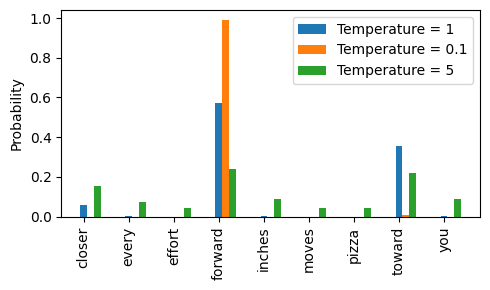

In [81]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

* A temperature of 1 divides the logits by 1 before passing them to the softmax
function to compute the probability scores. In other words, using a
temperature of 1 is the same as not using any temperature scaling. In this
case, the tokens are selected with a probability equal to the original softmax
probability scores via the multinomial sampling function in PyTorch.
* For example, for the temperature setting 1, the token corresponding to
"forward" would be selected with about 60% of the time, as we can see in
Figure above

* We can see that the rescaling via temperature 0.1 results in a sharper distribution, approaching torch.argmax, such that the most likely word is almost always selected:

In [82]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


* The rescaled probabilities via temperature 5 are more uniformly distributed:

In [83]:
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


* Assuming an LLM input "every effort moves you", using the approach above can sometimes result in nonsensical texts, such as "every effort moves you pizza", 3.2% of the time (32 out of 1000 times)

## 5.3.2 Top-k sampling

* To be able to use higher temperatures to increase output diversity and to reduce the probability of nonsensical sentences, we can restrict the sampled tokens to the top-k most likely tokens:

In the previous section, we implemented a probabilistic sampling approach
coupled with temperature scaling to increase the diversity of the outputs. We
saw that higher temperature values result in more uniformly distributed nexttoken probabilities, which result in more diverse outputs as it reduces the
likelihood of the model repeatedly selecting the most probable token. This
method allows for exploring less likely but potentially more interesting and
creative paths in the generation process. However, One downside of this
approach is that it sometimes leads to grammatically incorrect or completely
nonsensical outputs such as "every effort moves you pizza".

-----------------------------------------------------------------------------------------
*In top-k sampling, we can restrict the sampled tokens to the top-k most likely
tokens and exclude all other tokens from the selection process by masking
their probability scores, as illustrated in Figure*

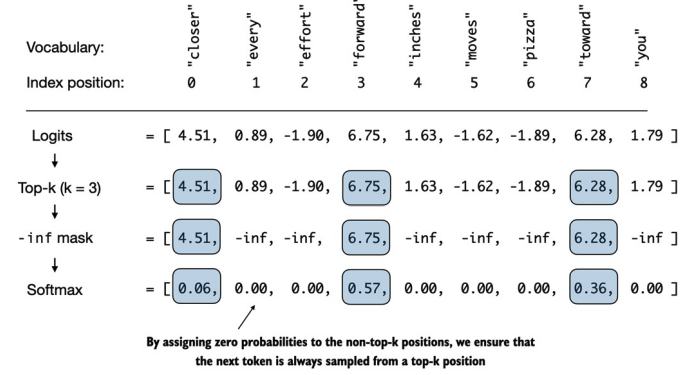

**Using top-k sampling with k=3, we focus on the 3 tokens associated with the highest
logits and mask out all other tokens with negative infinity (-inf) before applying the softmax
function. This results in a probability distribution with a probability value 0 assigned to all nontop-k tokens**

* (Please note that the numbers in this figure are truncated to two digits after the decimal point to reduce visual clutter. The values in the Softmax row should add up to 1.0.)
* In code, we can implement this as follows:

In [84]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [85]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [86]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## 5.3.3 Modifying the text generation function

The previous two subsections introduced two concepts to increase the
diversity of LLM-generated text: temperature sampling and top-k sampling.
In this section, we combine and add these concepts to modify the
generate_simple function we used to generate text via the LLM earlier,
creating a new generate function:

**Listing 5.4 A modified text generation function with more diversity**

In [87]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

Let's now see this new generate function in action:

In [88]:

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


## 5.4 Loading and saving model weights in PyTorch

* Training LLMs is computationally expensive, so it's crucial to be able to save and load LLM weights

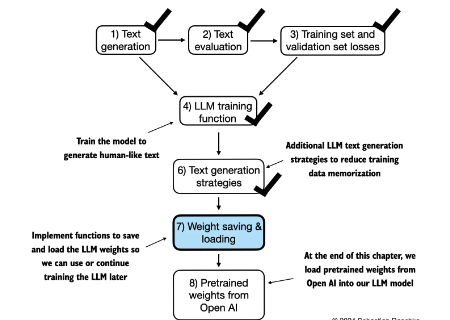

*The recommended way in PyTorch is to save the model weights, the so-called state_dict via by applying the torch.save function to the .state_dict() method:*

In [89]:
torch.save(model.state_dict(), "model.pth")

* Then we can load the model weights into a new GPTModel model instance as follows:

In [90]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

* It's common to train LLMs with adaptive optimizers like Adam or AdamW instead of regular SGD
* These adaptive optimizers store additional parameters for each model weight, so it makes sense to save them as well in case we plan to continue the pretraining later:

In [91]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [92]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 5.5 Loading pretrained weights from OpenAI

* Previously, we only trained a small GPT-2 model using a very small short-story book for educational purposes
* Interested readers can also find a longer pretraining run on the complete Project Gutenberg book corpus in `../03_bonus_pretraining_on_gutenberg`
* Fortunately, we don't have to spend tens to hundreds of thousands of dollars to pretrain the model on a large pretraining corpus but can load the pretrained weights provided by OpenAI
* For an alternative way to load the weights from the Hugging Face Hub, see `../02_alternative_weight_loading`
* First, some boilerplate code to download the files from OpenAI and load the weights into Python
* Since OpenAI used TensorFlow, we will have to install and use TensorFlow for loading the weights; tqdm is a progress bar library


In [94]:
#pip install tensorflow tqdm

In [95]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.17.0
tqdm version: 4.66.6


In [97]:
#gpt_download file
import os
import urllib.request

# import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


def download_file(url, destination):
    # Send a GET request to download the file

    try:
        with urllib.request.urlopen(url) as response:
            # Get the total file size from headers, defaulting to 0 if not present
            file_size = int(response.headers.get("Content-Length", 0))

            # Check if file exists and has the same size
            if os.path.exists(destination):
                file_size_local = os.path.getsize(destination)
                if file_size == file_size_local:
                    print(f"File already exists and is up-to-date: {destination}")
                    return

            # Define the block size for reading the file
            block_size = 1024  # 1 Kilobyte

            # Initialize the progress bar with total file size
            progress_bar_description = os.path.basename(url)  # Extract filename from URL
            with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
                # Open the destination file in binary write mode
                with open(destination, "wb") as file:
                    # Read the file in chunks and write to destination
                    while True:
                        chunk = response.read(block_size)
                        if not chunk:
                            break
                        file.write(chunk)
                        progress_bar.update(len(chunk))  # Update progress bar
    except urllib.error.HTTPError:
        s = (
            f"The specified URL ({url}) is incorrect, the internet connection cannot be established,"
            "\nor the requested file is temporarily unavailable.\nPlease visit the following website"
            " for help: https://github.com/rasbt/LLMs-from-scratch/discussions/273")
        print(s)


# Alternative way using `requests`
"""
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file
"""


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

* We can then download the model weights for the 124 million parameter model as follows:

In [98]:

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 58.2kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 5.04MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 29.2kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:11<00:00, 42.8MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 3.52MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 2.57MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 2.02MiB/s]


In [99]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [100]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [101]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


* Alternatively, "355M", "774M", and "1558M" are also supported model_size arguments
* The difference between these differently sized models is summarized in the figure below:

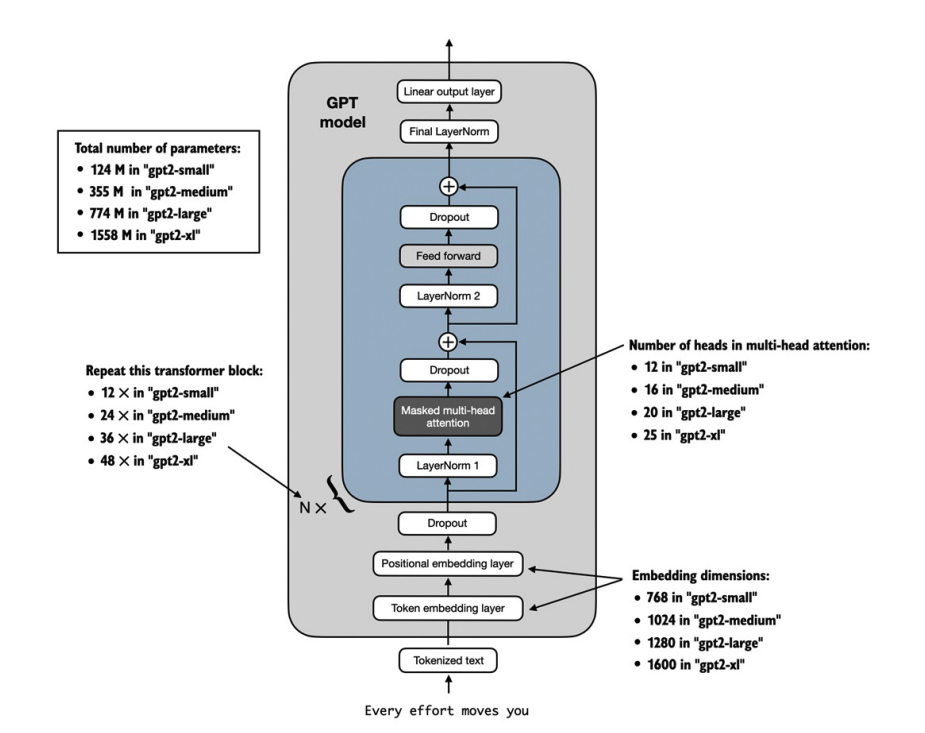

**GPT-2 LLMs come in several different model sizes, ranging from 124 million to 1,558
million parameters. The core architecture is the same, with the only difference being the
embedding sizes and the number of times individual components like the attention heads and
transformer blocks are repeated.**

* As illustrated in Figure above, the overall architecture of the differently-sized
GPT-2 models remains the same, except that different architectural elements
are repeated different numbers of times, and the embedding size differs. The
remaining code in this chapter is also compatible with these larger models.
* After loading the GPT-2 model weights into Python, we still need to transfer
them from the settings and params dictionaries into our GPTModel instance.
* First, we create a dictionary that lists the differences between the different
GPT model sizes, as explained in Figure above:

------------------------------------------------------------------------------------------
* Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our GPTModel instance
* First, we initialize a new GPTModel instance
* Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting `qkv_bias` to `True` in our implementation, too
* We are also using the `1024` token context length that was used by the original GPT-2 model(s)

In [102]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

* The next task is to assign the OpenAI weights to the corresponding weight tensors in our `GPTModel` instance

In [103]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [104]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

* If the model is loaded correctly, we can use it to generate new text using our previous `generate` function:

In [105]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


* We know that we loaded the model weights correctly because the model can generate coherent text; if we made even a small mistake, the model would not be able to do that
* For an alternative way to load the weights from the Hugging Face Hub, see ../02_alternative_weight_loading
* If you are interested in seeing how the GPT architecture compares to the Llama architecture (a popular LLM developed by Meta AI), see the bonus content at ../07_gpt_to_llama